# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

***Citation: Thoughout this notebook we frequently use, or modify and implement, selected code from in class resources and recitation documents. Additionally, where outside resources were consulted, we have made note. With regard to official documentation pages we have included links and descriptions for the documentation we referenced but have also made the assumption, likely the majority of the time, that referencing official documentation, either by directly visiting the corresponding webpage or by viewing them through tools within our IDE, falls within the space of general knowledge and does not merit explicit citation. We believe it is the assumption of those who deal with code the documentation is referenced freely and often.***

In [ ]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score, f1_score, precision_recall_curve, average_precision_score

from sklearn.calibration import calibration_curve

from imblearn.over_sampling import SMOTE

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
# from sklearn.externals.six import StringIO
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
# from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

***Module Import changes: I was not able to import StringIO from sklearn.externals.six. Some online searching, at the stackoverflow page linked below, suggested it is because the newest version of sklearn doesn't have that option, and the recommendation was to import StringIO directly from the six package itself, which I what I have done. Here is a link to the posting: https://stackoverflow.com/questions/61901365/modulenotfounderror-no-module-named-sklearn-externals-six***

In [ ]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)

    all_perc_diff = []

    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass

    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass

    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False

    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break

    return out

## Define a default random seed and an output file

In [ ]:
default_seed = 1
output_file = "output_sample"

In [ ]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [ ]:
# # Read the data and features from the pickle file saved in CS-Phase 2

# from google.colab import drive
# import pickle
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/ML4PS Case Study/Phase3

# data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [ ]:
# DATA IMPORT (SAM)

# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [ ]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = [True if i == 'Charged Off' or i == 'Default' else False for i in data['loan_status']]

In [ ]:
data.head(2)

,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,total_pymnt,recoveries,last_pymnt_d,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,outcome
0,1077501,5000.0,5000.0,36 months,10.65,B,10+ years,RENT,24000.0,Verified,...,5863.155187,0.0,2015-01-01,37.027454,36,0.057544,0.055947,0.413340,1.075884,False
1,1077430,2500.0,2500.0,60 months,15.27,C,< 1 year,RENT,30000.0,Source Verified,...,1014.530000,122.9,2013-04-01,16.000329,60,-0.118838,-0.118838,0.058081,0.401688,True


In [ ]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [ ]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], len(data), p=[0.7,0.3])

In [ ]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [ ]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows

    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.

    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''

    np.random.seed(random_state)

    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values

    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False

    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]

    y_train = y[ filter_train ]
    y_test = y[ filter_test ]

    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train,
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}

    return out

In [ ]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen

    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.

    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.

    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not
                      output probabilities.
    '''

    np.random.seed(random_state)

    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']

    X_test = data_dict['X_test']
    y_test = data_dict['y_test']

    filter_train = data_dict['train_set']

    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)

    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()

    best_model = cv_model.best_estimator_

    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")

    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------

    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        precision, recall, threshold = precision_recall_curve(y_test, y_pred_probs)

        probs_predicted = True
    except:
        probs_predicted = False

    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()

        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]

        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))

        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)

    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:
            plt.figure(figsize = (13, 6.75))
            plt.subplot(3, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(3, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            # Included Precision recall curve
            plt.subplot(3, 2, 2)

            plt.title("PR Curve (AUC = %0.2f)"% average_precision_score(y_test, y_pred_probs))
            plt.plot(recall, precision, 'b')
            plt.ylim((0,1.1))
            plt.xlabel('Recall')
            plt.ylabel('Precision')

            plt.subplot(3, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')

            plt.subplot(3, 2, 5)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')

            #plt.tight_layout()
            plt.show()

    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)

    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)

    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)

    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}

    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})

    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))

        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))

        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )

        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )

    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [ ]:
data.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
       'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
       'recoveries', 'last_pymnt_d', 'loan_length', 'term_num', 'ret_PESS',
       'ret_OPT', 'ret_INTa', 'ret_INTb', 'outcome', 'cr_hist', 'train'],
      dtype='object')

In [ ]:
## define your set of features to use in different models
your_features = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'purpose', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
       'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
       'recoveries', 'last_pymnt_d', 'loan_length', 'term_num', 'ret_PESS',
       'ret_OPT', 'ret_INTa', 'ret_INTb']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset= your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

***We modified the fit_classification function to also display a Precision-Recall curve***

### Random Classifier

  Model: Random Classifier
Fit time: 0.07 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7717
              precision    recall  f1-score   support

  No default     0.7717    1.0000    0.8711     15434
     Default     0.0000    0.0000    0.0000      4566

    accuracy                         0.7717     20000
   macro avg     0.3859    0.5000    0.4356     20000
weighted avg     0.5955    0.7717    0.6723     20000



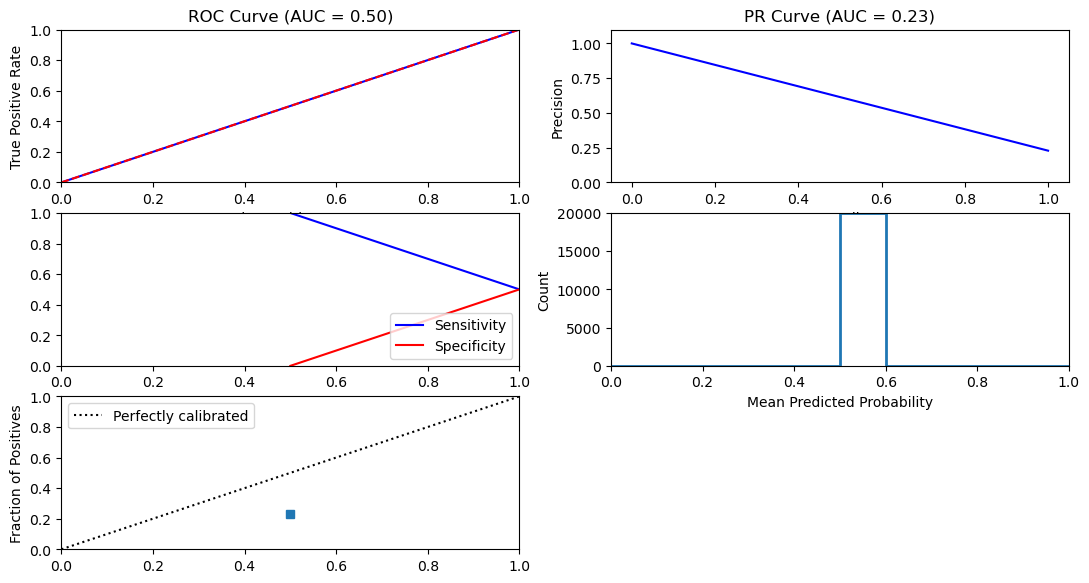


Similarity to LC grade ranking:  nan
Brier score: 0.25
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.50096667]


In [ ]:
## Train and test a Dummy classifier with strategy 'uniform' so that each class has equal probability
random_clf = DummyClassifier(strategy='uniform')
gnb = fit_classification(random_clf, data_dict,
                          model_name = "Random Classifier",
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

### Naive Bayes

  Model: Naive Bayes
Fit time: 0.82 seconds
Optimal parameters:
{'priors': [0.5, 0.5]}

Accuracy-maximizing threshold was: 0.9992520091218267
Accuracy:  0.77875
              precision    recall  f1-score   support

  No default     0.7952    0.9608    0.8702     15434
     Default     0.5522    0.1634    0.2522      4566

    accuracy                         0.7788     20000
   macro avg     0.6737    0.5621    0.5612     20000
weighted avg     0.7397    0.7788    0.7291     20000



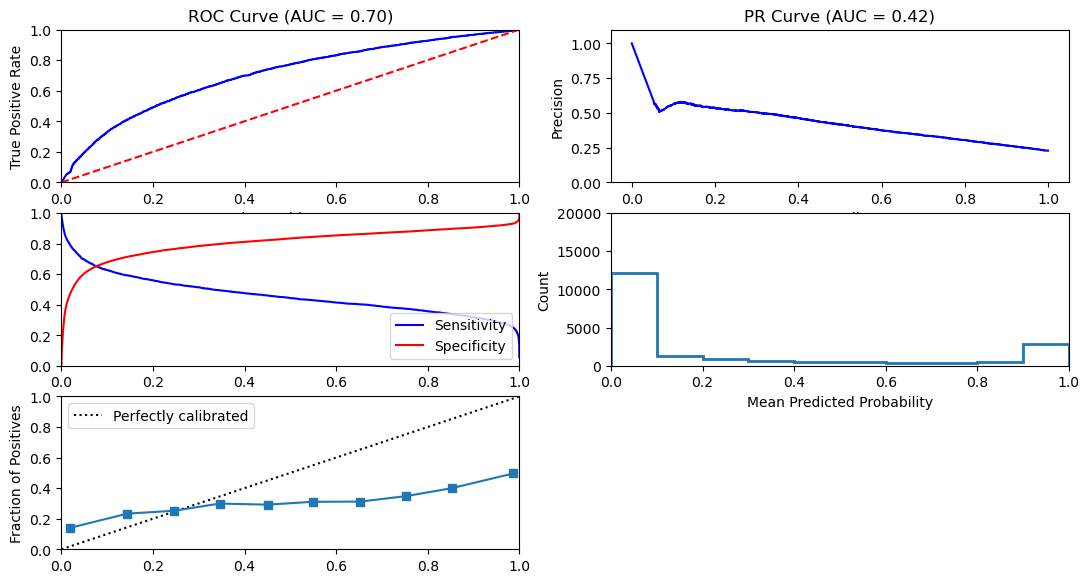


Similarity to LC grade ranking:  0.5915701661609115
Brier score: 0.21542375770778144
Were parameters on edge? : False
Score variations around CV search grid : 7.71892331959497
[0.60453333 0.62683333 0.64243333 0.6551     0.61276667]


In [ ]:
## Train and test a naive bayes classifier
# prior_list = list(np.arange(0.1,1,0.1))
gnb_param_grid = {'priors':[[0.2,0.8],[0.3,0.7],[0.4,0.6],[0.5,0.5],[0.23,0.77]]}
gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict,
                          cv_parameters = gnb_param_grid,
                          model_name = "Naive Bayes",
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

### K-Nearest Neighbor Classifier

  Model: K-NN
Fit time: 781.68 seconds
Optimal parameters:
{'n_neighbors': 49}

Accuracy-maximizing threshold was: 0.4489795918367347
Accuracy:  0.77995
              precision    recall  f1-score   support

  No default     0.7933    0.9667    0.8715     15434
     Default     0.5692    0.1487    0.2358      4566

    accuracy                         0.7800     20000
   macro avg     0.6812    0.5577    0.5536     20000
weighted avg     0.7421    0.7800    0.7263     20000



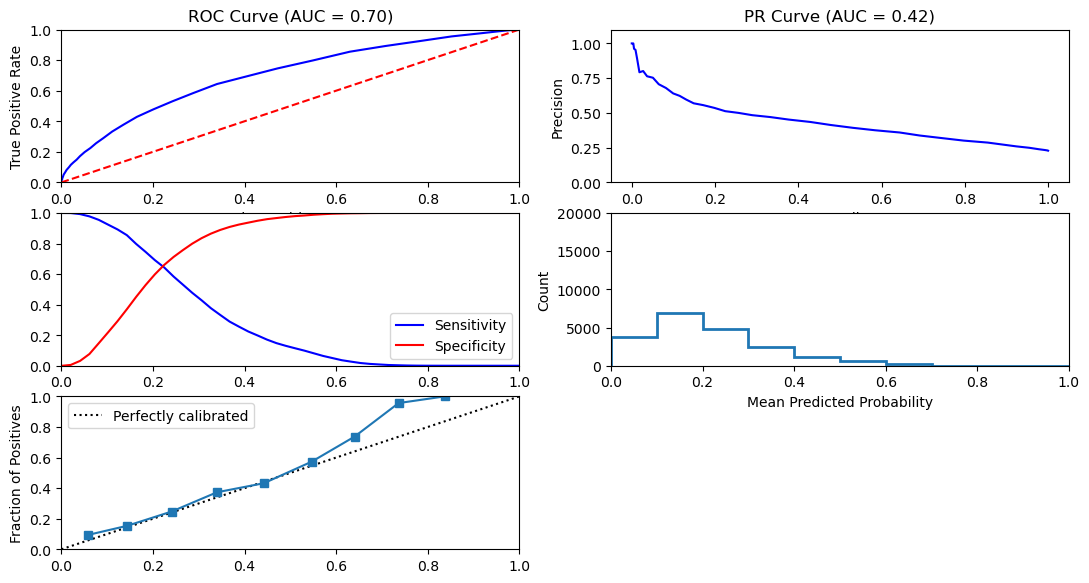


Similarity to LC grade ranking:  0.6538847605872306
Brier score: 0.1586738234069138
Were parameters on edge? : False
Score variations around CV search grid : 10.840443686006811
[0.69663333 0.76496667 0.74293333 0.77113333 0.75816667 0.77306667
 0.76566667 0.77506667 0.77116667 0.7778     0.7754     0.77796667
 0.77653333 0.77906667 0.77793333 0.77953333 0.779      0.7796
 0.77873333 0.77903333 0.77786667 0.77966667 0.7792     0.77963333
 0.77893333 0.7791     0.78023333 0.77986667 0.78006667 0.78
 0.78       0.77976667 0.77936667 0.7795     0.78013333 0.77976667
 0.77936667 0.77986667 0.7805     0.7806     0.7807     0.78066667
 0.7812     0.78073333 0.7809     0.7807     0.78113333 0.78093333
 0.78133333 0.78083333]


In [ ]:
knn= KNeighborsClassifier()
k_range= list(range(1,51))
knn_param_grid=dict(n_neighbors=k_range)
knn = fit_classification(knn, data_dict,
                          cv_parameters = knn_param_grid,
                          model_name = "K-NN",
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

### $l_1$ regularized logistic regression

  Model: L1 Regularized Logisitic Regression
Fit time: 59.02 seconds
Optimal parameters:
{'C': 0.91}

Accuracy-maximizing threshold was: 0.49334519190868037
Accuracy:  0.79295
              precision    recall  f1-score   support

  No default     0.8039    0.9677    0.8783     15434
     Default     0.6495    0.2021    0.3083      4566

    accuracy                         0.7930     20000
   macro avg     0.7267    0.5849    0.5933     20000
weighted avg     0.7687    0.7930    0.7481     20000



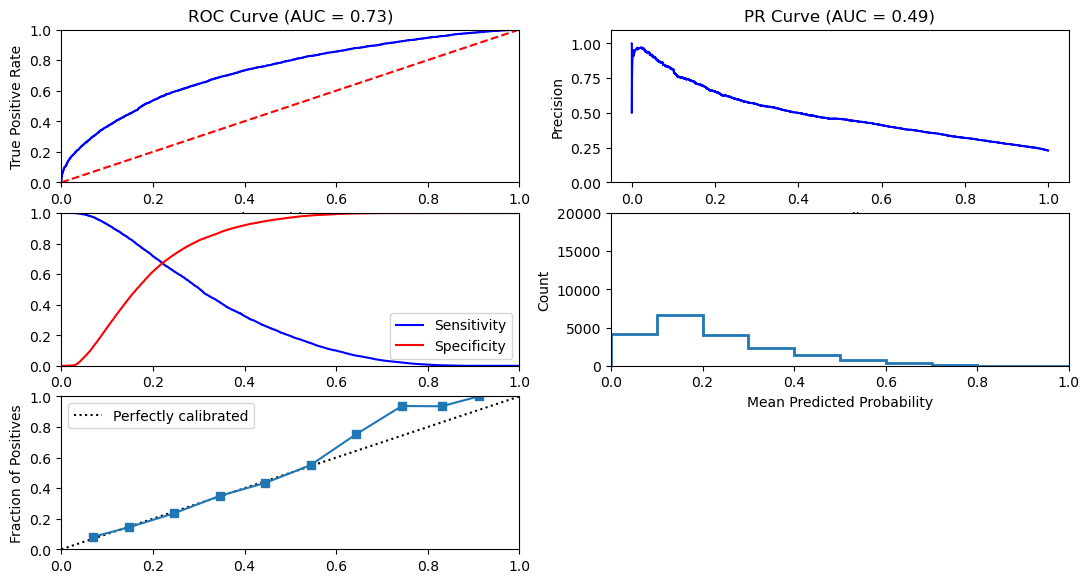


Similarity to LC grade ranking:  0.6398322756202827
Brier score: 0.1507847443129031
Were parameters on edge? : False
Score variations around CV search grid : 2.4783667982861255
[0.77386667 0.79353333 0.79323333 0.793      0.7933     0.79326667
 0.79323333 0.79326667 0.79333333 0.79333333 0.79336667 0.79333333]


In [ ]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters = {
    'C': np.linspace(1e-3, 10, 12)
}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters,
                                model_name = "L1 Regularized Logisitic Regression", random_state = 0)

### $l_2$ regularized logistic regression

  Model: L2 Regularized Logistic Regression
Fit time: 12.72 seconds
Optimal parameters:
{'C': 0.91}

Accuracy-maximizing threshold was: 0.4822027968372358
Accuracy:  0.79175
              precision    recall  f1-score   support

  No default     0.8052    0.9631    0.8771     15434
     Default     0.6303    0.2124    0.3178      4566

    accuracy                         0.7917     20000
   macro avg     0.7177    0.5878    0.5974     20000
weighted avg     0.7653    0.7917    0.7494     20000



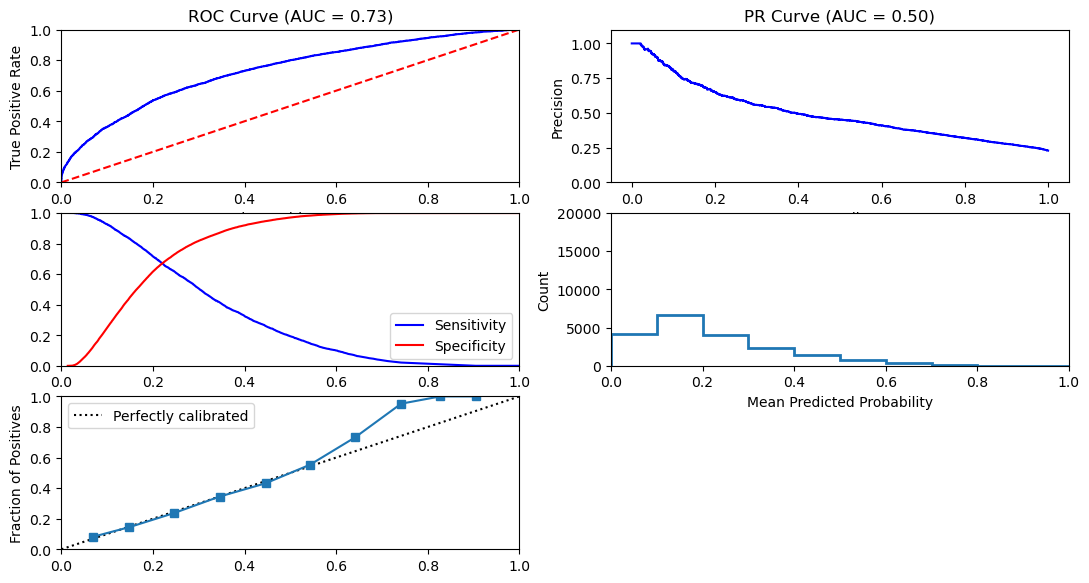


Similarity to LC grade ranking:  0.6411633739011544
Brier score: 0.15102597030243572
Were parameters on edge? : False
Score variations around CV search grid : 2.5723877465379736
[0.7739     0.79433333 0.79413333 0.7938     0.7938     0.7939
 0.794      0.794      0.79383333 0.79366667 0.7939     0.79433333]


In [ ]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {
    'C': np.linspace(1e-3, 10, 12)
}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters,
                                   model_name= "L2 Regularized Logistic Regression", random_state=0)

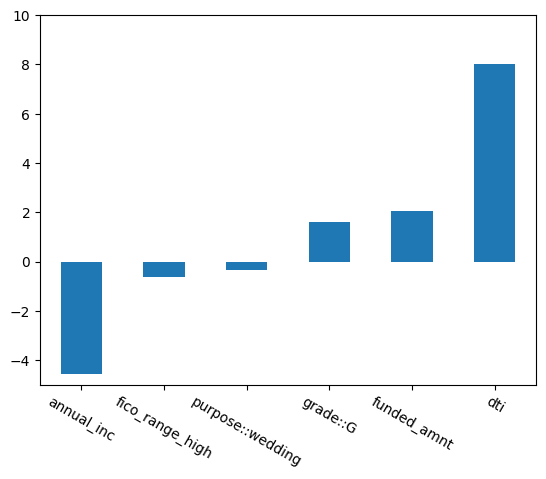

In [ ]:
## plot top 3 features with the most positive (and negative) weights
top_and_bottom_idx = list(np.argsort(l1_logistic['model'].coef_)[0,:3]) + list(np.argsort(l1_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l1_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree
Fit time: 26.94 seconds
Optimal parameters:
{'max_depth': 4.0}

Accuracy-maximizing threshold was: 0.6
Accuracy:  0.7962
              precision    recall  f1-score   support

  No default     0.7915    0.9992    0.8833     15434
     Default     0.9748    0.1102    0.1980      4566

    accuracy                         0.7962     20000
   macro avg     0.8831    0.5547    0.5406     20000
weighted avg     0.8333    0.7962    0.7268     20000



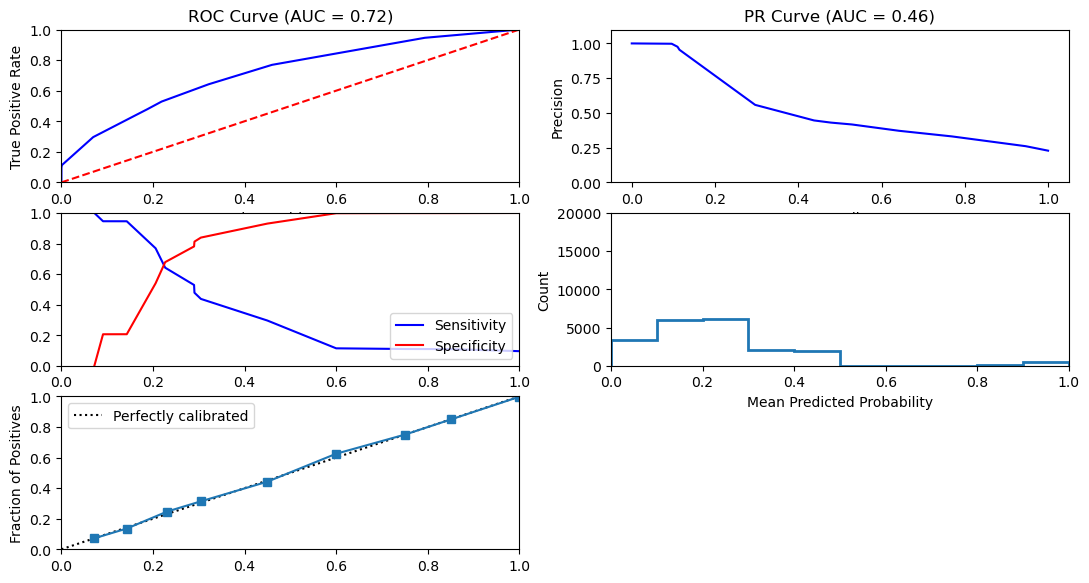


Similarity to LC grade ranking:  0.8631159507832734
Brier score: 0.1492138252147639
Were parameters on edge? : False
Score variations around CV search grid : 13.941142044979513
[0.79686667 0.79686667 0.7972     0.7974     0.7798     0.77706667
 0.77596667 0.77546667 0.7709     0.76733333 0.76036667 0.75743333
 0.74896667 0.74186667 0.7366     0.72953333 0.72286667 0.71846667
 0.71373333 0.70483333 0.70466667 0.69836667 0.6945     0.6947
 0.6917     0.68843333 0.68773333 0.68716667 0.6879     0.68623333]


In [ ]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':np.linspace(1, 30, 30)}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters,
                                   model_name= "Decision Tree", random_state=0)

### Random forest

  Model: Random Forest
Fit time: 1753.19 seconds
Optimal parameters:
{'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 300}

Accuracy-maximizing threshold was: 0.3244667838992385
Accuracy:  0.7788
              precision    recall  f1-score   support

  No default     0.8334    0.8917    0.8615     15434
     Default     0.5204    0.3973    0.4506      4566

    accuracy                         0.7788     20000
   macro avg     0.6769    0.6445    0.6560     20000
weighted avg     0.7619    0.7788    0.7677     20000



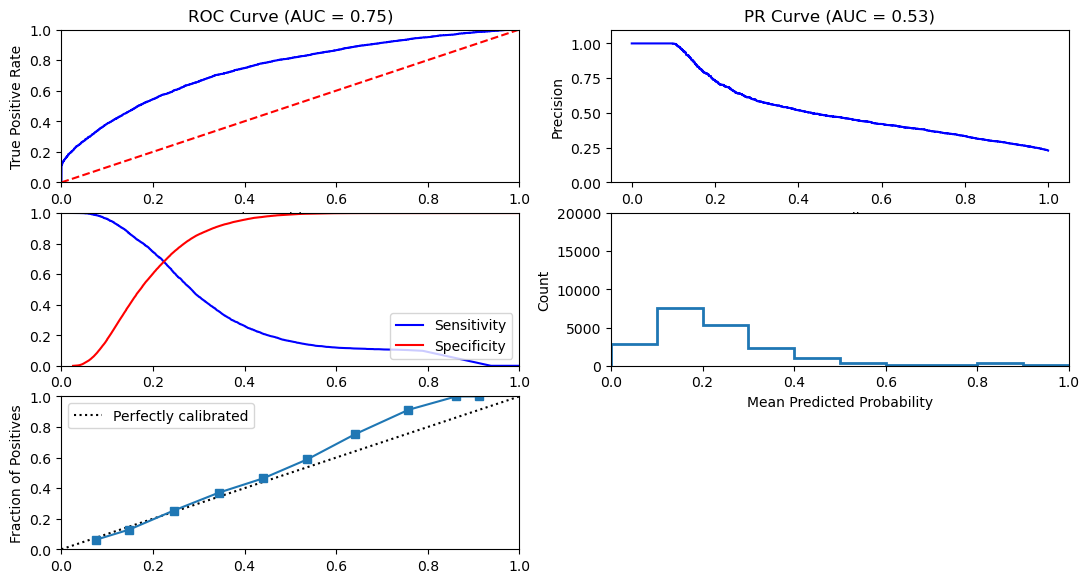


Similarity to LC grade ranking:  0.633000651861455
Brier score: 0.1456478857930804
Were parameters on edge? : True
Score variations around CV search grid : 0.2580967446507223
[0.79963333 0.7994     0.79903333 0.799      0.79896667 0.79886667
 0.7992     0.79896667 0.8004     0.80063333 0.8002     0.8005
 0.7994     0.80043333 0.7997     0.80026667 0.7994     0.79903333
 0.79913333 0.79946667 0.79893333 0.7992     0.79916667 0.79903333
 0.80073333 0.79976667 0.80046667 0.80026667 0.80023333 0.7998
 0.7996     0.79993333 0.79953333 0.79946667 0.79956667 0.79903333
 0.79893333 0.7987     0.79893333 0.79866667 0.80013333 0.80036667
 0.80053333 0.8        0.8001     0.80003333 0.7999     0.8004    ]


In [ ]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {
                  'max_depth': [80, 90, 100],
                  'max_features': [3, 4],
                  'min_samples_leaf': [5, 7],
                  'min_samples_split': [12, 16],
                  'n_estimators': [300, 400]}

random_forest = fit_classification(random_forest, data_dict, cv_parameters,
                                   model_name = "Random Forest", random_state=0)

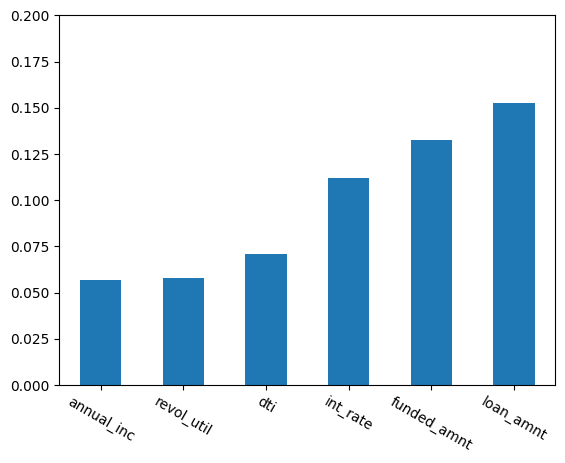

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:])
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-layer Perceptron
Fit time: 2020.65 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (5, 5), 'learning_rate_init': 0.001}

Accuracy-maximizing threshold was: 0.4702660186468698
Accuracy:  0.7992
              precision    recall  f1-score   support

  No default     0.8069    0.9725    0.8820     15434
     Default     0.6964    0.2135    0.3269      4566

    accuracy                         0.7992     20000
   macro avg     0.7517    0.5930    0.6044     20000
weighted avg     0.7817    0.7992    0.7553     20000



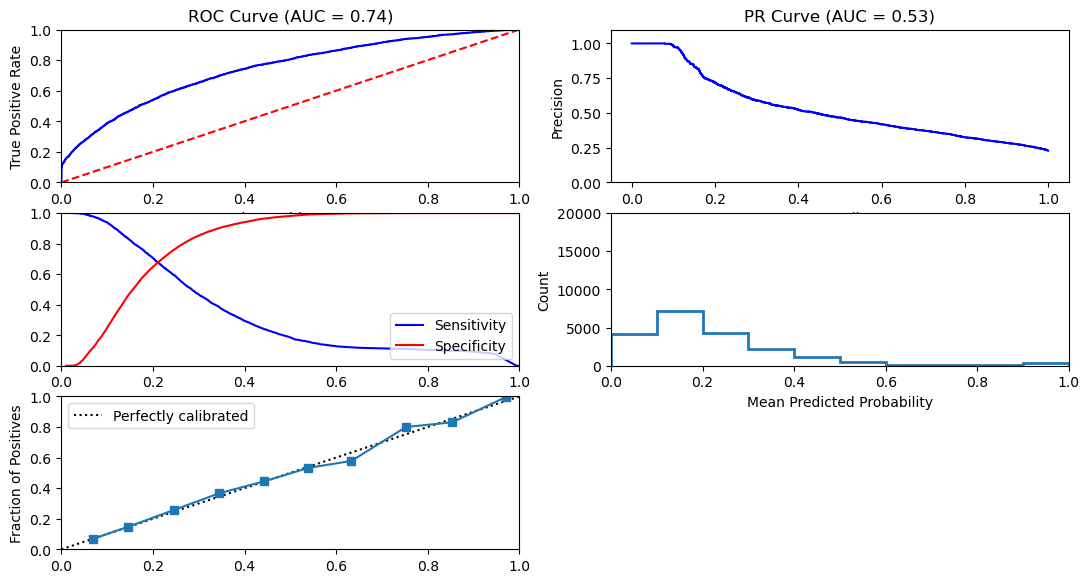


Similarity to LC grade ranking:  0.675154870322029
Brier score: 0.14560096549877427
Were parameters on edge? : True
Score variations around CV search grid : 3.2424772859881537
[0.7982     0.79596667 0.7998     0.79793333 0.79866667 0.7951
 0.7942     0.79823333 0.79573333 0.79646667 0.7957     0.79776667
 0.79366667 0.78973333 0.7936     0.7947     0.792      0.79333333
 0.79273333 0.79153333 0.7926     0.79233333 0.79263333 0.78963333
 0.79546667 0.7961     0.7961     0.79626667 0.79756667 0.79813333
 0.78813333 0.78876667 0.78713333 0.78666667 0.77386667 0.77386667
 0.77386667 0.77653333 0.77386667 0.7745     0.77386667 0.77386667
 0.77386667 0.77386667 0.77386667 0.77386667 0.77386667 0.77386667]


In [ ]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {
    'hidden_layer_sizes': [(10, 6), (5, 5), (8, 6, 2)], # also tried other values such as (100), (50, 50), (25, 25), (16, 16), (24, 16, 8)
    'activation': ['tanh', 'logistic'], # also tried relu
    'alpha': np.linspace(1e-3, 1, 4),
    'learning_rate_init': [0.001, 0.01],
}

mlp = fit_classification(mlp, data_dict, cv_parameters,
                                   model_name = "Multi-layer Perceptron", random_state=0)

***After training the models, the team noticed that the performance for No Default loans was generally much better than for Default loans. The team decided that it could be because the dataset was not balanced and attempted to use SMOTE to resample and balance the data. However, we ran into some issues modifying the prepare_data function and decided to just make a note of this, in case we are unable to get it to work.***

### Support Vector Machine

***We tried to train an SVM model with a wide range of hyperparameter values, but we had to remove because the model ran for several hours without producing any result***

In [ ]:
# # fit SVM
# from sklearn.svm import SVC
# svc = SVC()

# cv_parameters = {
#     'kernel': ['linear', 'rbf'],
#     #'C': np.linspace(10, 100, 1000),
#     #'gamma': [1e-3, 1e-4]
# }
# # view metrics
# svc = fit_classification(svc, data_dict, cv_parameters,
#                                 model_name = "SVC", random_state = 0)

  Model: SVC
Fit time: 155.01 seconds
Optimal parameters:
{'kernel': 'linear'}

Accuracy:  0.77565
              precision    recall  f1-score   support

  No default     0.7791    0.9900    0.8720     15434
     Default     0.6021    0.0510    0.0941      4566

    accuracy                         0.7756     20000
   macro avg     0.6906    0.5205    0.4830     20000
weighted avg     0.7387    0.7756    0.6944     20000


Similarity to LC grade ranking:  0.22266364546502512


In [ ]:
# fit SVM
# from sklearn.svm import SVC
# svc = SVC()

# cv_parameters = {
#     'kernel': ['linear'],
#     #'C': np.linspace(10, 100, 1000),
#     'gamma': [1e-3, 1e-4, 1e-5]
# }
# # view metrics
# svc = fit_classification(svc, data_dict, cv_parameters,
#                                 model_name = "SVC", random_state = 0)

  Model: SVC
Fit time: 412.18 seconds
Optimal parameters:
{'gamma': 0.001, 'kernel': 'linear'}

Accuracy:  0.77565
              precision    recall  f1-score   support

  No default     0.7791    0.9900    0.8720     15434
     Default     0.6021    0.0510    0.0941      4566

    accuracy                         0.7756     20000
   macro avg     0.6906    0.5205    0.4830     20000
weighted avg     0.7387    0.7756    0.6944     20000


Similarity to LC grade ranking:  0.09256598503143883


In [ ]:
# # fit SVM
# from sklearn.svm import SVC
# svc = SVC()

# cv_parameters = {
#     'kernel': ['linear'],
#     'C': np.linspace(10, 100, 1000),
#     #'gamma': [1e-3, 1e-4]
# }
# # view metrics
# svc = fit_classification(svc, data_dict, cv_parameters,
#                                 model_name = "SVC", random_state = 0)

## Train and Test logistic regression model with features derived by LendingClub

Features Derived by LendingClub:

- grade
- int_rate (derived by LendingClub, in response to risk factors and other circumstances surrounding the loan applicant)

Features correlated with LC features:
- cr_hist (
- fico_range_low
- fico_range_high
- dti

  Model: L1 Regularized Logisitic Regression with 1 LC feature
Fit time: 2.78 seconds
Optimal parameters:
{'C': 0.91}

Accuracy-maximizing threshold was: 0.5300117387629688
Accuracy:  0.7726
              precision    recall  f1-score   support

  No default     0.7729    0.9987    0.8714     15434
     Default     0.6552    0.0083    0.0164      4566

    accuracy                         0.7726     20000
   macro avg     0.7141    0.5035    0.4439     20000
weighted avg     0.7461    0.7726    0.6762     20000



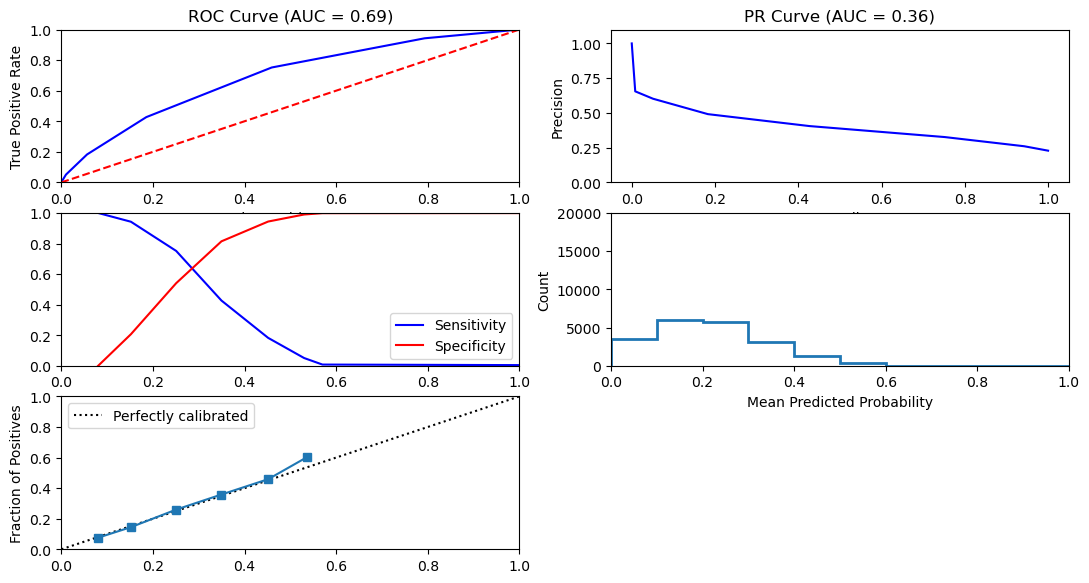


Similarity to LC grade ranking:  1.0
Brier score: 0.16110060781973803
Were parameters on edge? : False
Score variations around CV search grid : 0.19345685912039487
[0.77386667 0.77536667 0.77536667 0.77536667 0.77536667 0.77536667
 0.77536667 0.77536667 0.77536667 0.77536667 0.77536667 0.77536667]


In [ ]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
lendingclub_features = ['grade', 'int_rate']
correlated_with_lc_features = ['dti', 'fico_range_low', 'fico_range_high', 'cr_hist']

a_lendingclub_feature = ['grade']

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1', solver='liblinear')

cv_parameters = {
    'C': np.linspace(1e-3, 10, 12)
}

lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict, cv_parameters,
                                model_name = "L1 Regularized Logisitic Regression with 1 LC feature", random_state = 0)

  Model: L2 Regularized Logisitic Regression with 1 LC feature
Fit time: 6.11 seconds
Optimal parameters:
{'C': 1.819}

Accuracy-maximizing threshold was: 0.5294225582832939
Accuracy:  0.7726
              precision    recall  f1-score   support

  No default     0.7729    0.9987    0.8714     15434
     Default     0.6552    0.0083    0.0164      4566

    accuracy                         0.7726     20000
   macro avg     0.7141    0.5035    0.4439     20000
weighted avg     0.7461    0.7726    0.6762     20000



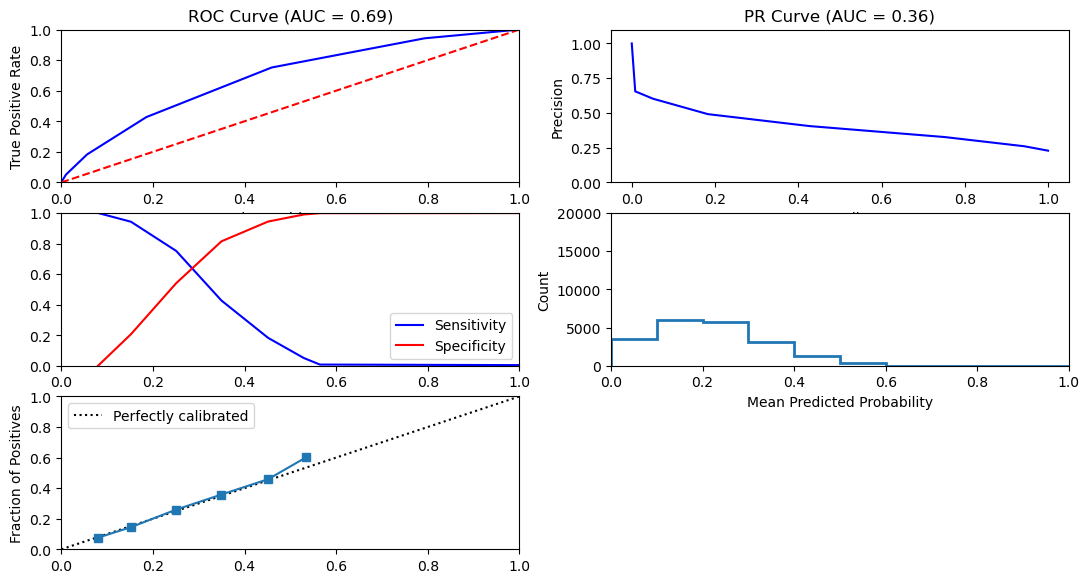


Similarity to LC grade ranking:  1.0
Brier score: 0.16110429942797774
Were parameters on edge? : False
Score variations around CV search grid : 0.19345685912039487
[0.77386667 0.77513333 0.77536667 0.77536667 0.77536667 0.77536667
 0.77536667 0.77536667 0.77536667 0.77536667 0.77536667 0.77536667]


In [ ]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2')

cv_parameters = {
    'C': np.linspace(1e-3, 10, 12)
}

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict, cv_parameters,
                                model_name = "L2 Regularized Logisitic Regression with 1 LC feature", random_state = 0)

## Train and test all the models you have tried previously after removing features derived by LendingClub

In [ ]:
non_lc_features = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'purpose', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
       'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
       'recoveries', 'last_pymnt_d', 'loan_length', 'term_num', 'ret_PESS',
       'ret_OPT', 'ret_INTa', 'ret_INTb']

data_dict = prepare_data(feature_subset = non_lc_features)

In [ ]:
models = {}

model_scores = {
    'l1LR': [],
    'l2LR': [],
    'naiveBayes': [],
    'decisionTree': [],
    'randForest': [],
    'mlp': [],
    'svm': []
}

In [ ]:
for i in range(100):
    l1LR = LogisticRegression(penalty='l1', solver='liblinear', C=0.91)

    l1LR = fit_classification(l1LR, data_dict, random_state=i+10, print_to_screen=False, output_to_file=False, model_name='L1 LogR')

    f1score = f1_score(data_dict['y_test'], l1LR['y_pred_labels'])
    model_scores['l1LR'].append(f1score)

    if 'l1LR' not in models:
        models['l1LR'] = l1LR['model']
    elif f1score > np.max(model_scores['l1LR']):
        models['l1LR'] = l1LR['model']

print('Model name: L1 LogR')
print(f"Average f1 score: {np.mean(model_scores['l1LR'])}")
print(f"Standard Deviation: {np.std(model_scores['l1LR'])}")

Model name: L1 LogR
Average f1 score: 0.3083619024668895
Standard Deviation: 9.873541073515861e-05


In [ ]:
for i in range(100):
    l2LR = LogisticRegression(penalty='l2', C=0.91)

    l2LR = fit_classification(l2LR, data_dict, random_state=i+10, print_to_screen=False, output_to_file=False, model_name='L2 LogR')

    f1score = f1_score(data_dict['y_test'], l2LR['y_pred_labels'])
    model_scores['l2LR'].append(f1score)

    if 'l2LR' not in models:
        models['l2LR'] = l2LR['model']
    elif f1score > np.max(model_scores['l2LR']):
        models['l2LR'] = l2LR['model']

print('Model name: L2 LogR')
print(f"Average f1 score: {np.mean(model_scores['l2LR'])}")
print(f"Standard Deviation: {np.std(model_scores['l2LR'])}")

Model name: L2 LogR
Average f1 score: 0.3177723177723176
Standard Deviation: 1.1102230246251565e-16


In [ ]:
for i in range(100):
    naiveBayes = GaussianNB()
    cv_parameters = {
        'priors': [[0.3,0.7],[0.4,0.6],[0.5,0.5]]
    }

    naiveBayes = fit_classification(naiveBayes, data_dict, cv_parameters, random_state=i+10, print_to_screen=False, output_to_file=False, model_name='Naive Bayes')

    f1score = f1_score(data_dict['y_test'], naiveBayes['y_pred_labels'])
    model_scores['naiveBayes'].append(f1score)

    if 'naiveBayes' not in models:
        models['naiveBayes'] = naiveBayes['model']
    elif f1score > np.max(model_scores['naiveBayes']):
        models['naiveBayes'] = naiveBayes['model']

print('Model name: Naive Bayes')
print(f"Average f1 score: {np.mean(model_scores['naiveBayes'])}")
print(f"Standard Deviation: {np.std(model_scores['naiveBayes'])}")

Model name: Naive Bayes
Average f1 score: 0.25215480817982083
Standard Deviation: 0.0


In [ ]:
for i in range(100):
    decisionTree = DecisionTreeClassifier()
    cv_parameters = {
        'max_depth': [3, 4, 5]
    }

    decisionTree = fit_classification(decisionTree, data_dict, cv_parameters, random_state=i+10, print_to_screen=False, output_to_file=False, model_name='Decision Tree')

    f1score = f1_score(data_dict['y_test'], decisionTree['y_pred_labels'])
    model_scores['decisionTree'].append(f1score)

    if 'decisionTree' not in models:
        models['decisionTree'] = decisionTree['model']
    elif f1score > np.max(model_scores['decisionTree']):
        models['decisionTree'] = decisionTree['model']

print('Model name: Decision Tree')
print(f"Average f1 score: {np.mean(model_scores['decisionTree'])}")
print(f"Standard Deviation: {np.std(model_scores['decisionTree'])}")

Model name: Decision Tree
Average f1 score: 0.19634856053037875
Standard Deviation: 0.005850160453312671


In [ ]:
for i in range(100):
    randForest = RandomForestClassifier()
    cv_parameters = {'max_depth': [90], 'max_features': [4], 'min_samples_leaf': [5], 'min_samples_split': [12], 'n_estimators': [300]}

    randForest = fit_classification(randForest, data_dict, cv_parameters, random_state=i+10, print_to_screen=False, output_to_file=False, model_name='Random Forest')

    f1score = f1_score(data_dict['y_test'], randForest['y_pred_labels'])
    model_scores['randForest'].append(f1score)

    if 'randForest' not in models:
        models['randForest'] = randForest['model']
    elif f1score > np.max(model_scores['randForest']):
        models['randForest'] = randForest['model']

print('Model name: Random Forest')
print(f"Average f1 score: {np.mean(model_scores['randForest'])}")
print(f"Standard Deviation: {np.std(model_scores['randForest'])}")

Model name: Random Forest
Average f1 score: 0.45900067125684446
Standard Deviation: 0.00467716019611921


In [ ]:
for i in range(100):
    mlp = MLPClassifier()
    cv_parameters = {
        'hidden_layer_sizes': [(5, 5)],
        'activation': ['tanh'],
        'learning_rate_init': [0.001],
    }

    mlp = fit_classification(mlp, data_dict, cv_parameters, random_state=i+10, print_to_screen=False, output_to_file=False, model_name='Multi Layer Perceptron')

    f1score = f1_score(data_dict['y_test'], mlp['y_pred_labels'])
    model_scores['mlp'].append(f1score)

    if 'mlp' not in models:
        models['mlp'] = mlp['model']
    elif f1score > np.max(model_scores['mlp']):
        models['mlp'] = mlp['model']

print('Model name: Multi Layer Perceptron')
print(f"Average f1 score: {np.mean(model_scores['mlp'])}")
print(f"Standard Deviation: {np.std(model_scores['mlp'])}")

Model name: Multi Layer Perceptron
Average f1 score: 0.31521676543052296
Standard Deviation: 0.01392569714315704


The classifier with the best performance was Random Forest

In [ ]:
YOURMODEL = models['randForest']

## Test the similarity of your predictions with LendingClub's Grades

***We chose to make this comparison using part of the code given to us in the fit_classification() function. Specifically, we found that this function was already providing us with a score for the similarity with LendingClub's grade by using the kendalltau() function for Kendall's Rank Correlation Coefficient. We researched this coefficient on its Wikipedia page (https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient). The Kendall Tau coefficient provides similarity from an ordinal perspective, which is exactly what we want to see in this situation. The LendingClub grades are ordinal because they follow a clear ranking, F is greater than E, which is greater than D, all the way up to A, which is the greatest. The Kendall Tau coefficient compares how similar the rankings of two different series are, so it is the best way to measure the similarity between loans ranked by our probability of default prediction and the ordinal LendingClub Grades.***

In [ ]:
tauRF, p_valueRF = kendalltau(YOURMODEL['y_pred_probs'], data.grade[data_dict['test_set']])
print("")
print("Similarity to LC grade ranking: ", tauRF)
print('P-value of the Similarity score:', p_valueRF)


Similarity to LC grade ranking:  0.6980438136708013
P-value of the Similarity score: 0.0


## Time stability test of YOURMODEL

**2010 Training Data, 2018 Testing Data**

***In order to get the code to run correctly we had to make a modification to the prepare_data function. The original version creates the train and test boolean filters by the date windows as well as the value of the 'train' column and other checks that work when we need to randomly select across all available years but cause a negative dimension error when we try to create a training set of only a single year. We removed the additional checks on the train and test filters so that the only criteria for True is that is is within the date boundaries, and all loans outisde those dates are assigned False and therefore not included.***

In [ ]:
# Part of Final notebook
def prepare_data_date(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows

    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.

    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''

    np.random.seed(random_state)

    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ((data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ((data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
#     print(filter_train.sum())
#     print(filter_test.sum())
#     print(type(data.issue_d.min()))
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False

    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]

    y_train = y[ filter_train ]
    y_test = y[ filter_test ]

    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train,
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}

    return out

In [ ]:
# Part of Final notebook
time_features = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'purpose', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
       'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
       'recoveries', 'last_pymnt_d', 'loan_length', 'term_num', 'ret_PESS',
       'ret_OPT', 'ret_INTa', 'ret_INTb', 'train']
# I also am going to try to do this without using the train column in my list

***Citation: Used the docs for datetime to find the correct way to create datetime object, https://docs.python.org/3/library/datetime.html***

  Model: YOURMODEL
Fit time: 10.04 seconds
Optimal parameters:
{'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 300}

Accuracy-maximizing threshold was: 0.2498867509158073
Accuracy:  0.746
              precision    recall  f1-score   support

  No default     0.7935    0.8893    0.8387      3712
     Default     0.5107    0.3331    0.4032      1288

    accuracy                         0.7460      5000
   macro avg     0.6521    0.6112    0.6209      5000
weighted avg     0.7207    0.7460    0.7265      5000



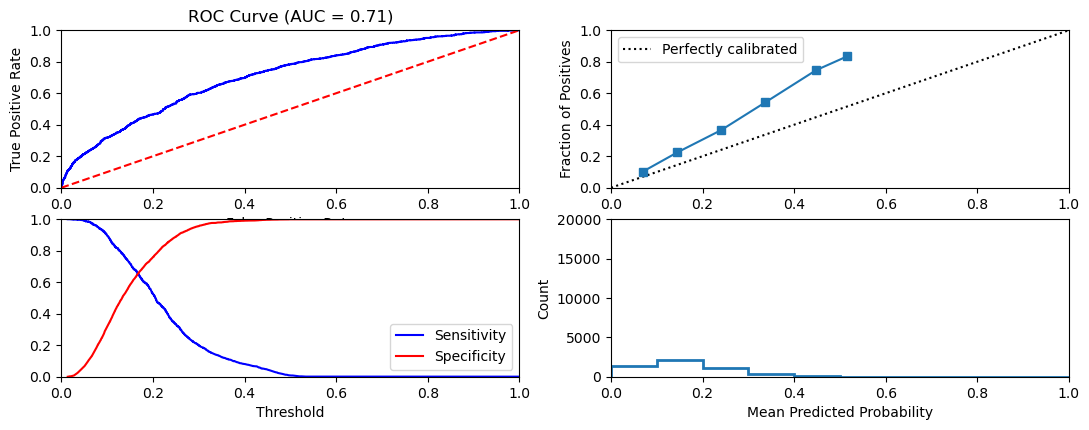


Similarity to LC grade ranking:  0.5787943057656381
Brier score: 0.18020260425018522
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.8643]


{'model': RandomForestClassifier(max_depth=90, max_features=4, min_samples_leaf=5,
                        min_samples_split=12, n_estimators=300),
 'y_pred_labels': array([False,  True, False, ...,  True, False,  True]),
 'y_pred_probs': array([0.15750029, 0.30115555, 0.07972673, ..., 0.25249819, 0.09599077,
        0.36320688])}

In [ ]:
# Part of Final notebook

## Define the time window of your train and test data
start_date_train = datetime.date(2010,1,1)
end_date_train = datetime.date(2010,12,31)
start_date_test = datetime.date(2018,1,1)
end_date_test = datetime.date(2018,12,31)

train_range = (start_date_train, end_date_train)
test_range = (start_date_test, end_date_test)

data_dict_test = prepare_data_date(data_subset = np.array([True]*len(data)),
                    n_samples_train = 10000,
                    n_samples_test = 5000,
                    feature_subset = time_features,
                    date_range_train = (start_date_train, end_date_train),
                    date_range_test = (start_date_test, end_date_test),
                    random_state = default_seed)

## Train and test YOURMODEL using this data
cv_parameters = {'max_depth': [90], 'max_features': [4], 'min_samples_leaf': [5], 'min_samples_split': [12],
                 'n_estimators': [300]}


fit_classification(YOURMODEL['model'], data_dict_test,
                          cv_parameters = cv_parameters,
                          model_name = 'YOURMODEL',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

**2017 Training Data, 2018 Testing Data**

44425
127964
<class 'datetime.date'>
  Model: YOURMODEL
Fit time: 7.27 seconds
Optimal parameters:
{'max_depth': 90, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 300}

Accuracy-maximizing threshold was: 0.2515426409163157
Accuracy:  0.7742857142857142
              precision    recall  f1-score   support

  No default     0.7913    0.9471    0.8622      5219
     Default     0.6335    0.2678    0.3765      1781

    accuracy                         0.7743      7000
   macro avg     0.7124    0.6075    0.6193      7000
weighted avg     0.7511    0.7743    0.7386      7000



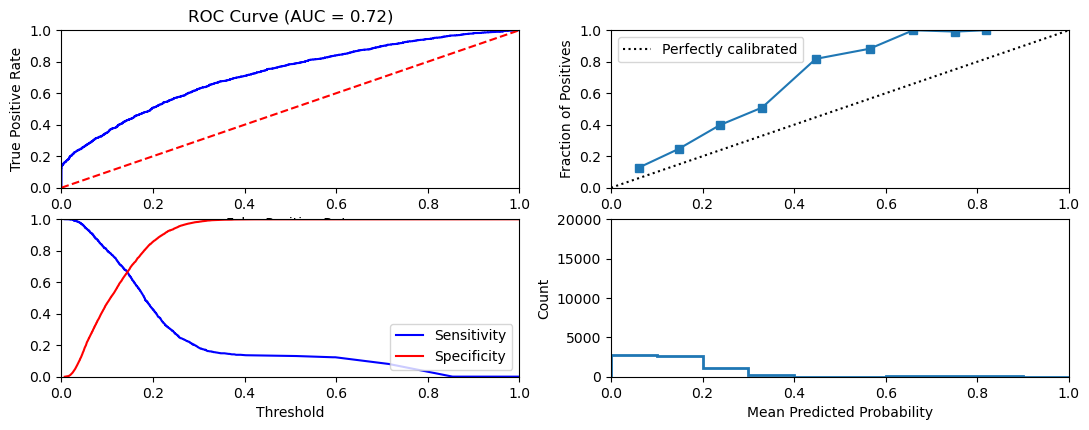


Similarity to LC grade ranking:  0.5864240408571455
Brier score: 0.1710242171248151
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.87066667]


{'model': RandomForestClassifier(max_depth=90, max_features=4, min_samples_leaf=5,
                        min_samples_split=12, n_estimators=300),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.0936096 , 0.0815577 , 0.06240712, ..., 0.08495713, 0.1629938 ,
        0.1471974 ])}

In [ ]:
#Part of final notebook

## Define the time window of your train and test data
start_date_train = datetime.date(2017,1,1)
end_date_train = datetime.date(2017,12,31)
start_date_test = datetime.date(2018,1,1)
end_date_test = datetime.date(2018,12,31)

data_dict_test = prepare_data_date(date_range_train = (start_date_train, end_date_train),
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = time_features)

## Train and test YOURMODEL using this data
cv_parameters = {'max_depth': [90], 'max_features': [4], 'min_samples_leaf': [5], 'min_samples_split': [12],
                 'n_estimators': [300]}


fit_classification(YOURMODEL['model'], data_dict_test,
                          cv_parameters = cv_parameters,
                          model_name = 'YOURMODEL',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

## Train and test YOURMODEL on the original data

In [ ]:
# re-load original LendingClub data
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [ ]:
# add 'outcome' attribute (True if Charged Off or Default, False otherwise)
data["outcome"] = [True if i == 'Charged Off' or i == 'Default' else False for i in data['loan_status']]

In [ ]:
# select features to include in training / testing (36 features + 'outcome' feature = 37 total)
your_features = ['id','loan_amnt', 'funded_amnt','funded_amnt_inv','term','int_rate','installment','grade',
                 'sub_grade','emp_title','emp_length','home_ownership','annual_inc','verification_status',
                 'issue_d','loan_status','purpose','title','zipcode','addr_state','dti','total_pymnt',
                 'delinq_2yrs','earliest_cr_line','open_acc','pub_rec','last_pymnt_d','last_pymnt_amnt',
                 'fico_range_high','fico_range_low','last_fico_range_high','last_fico_range_low',
                 'application_type','revol_bal','revol_util','recoveries','outcome']

#len(your_features)

In [ ]:
YOURMODEL_f1_scores = []

# define parameters (model is created inside loop)
cv_parameters = {'max_depth': [90], 'max_features': [4], 'min_samples_leaf': [5], 'min_samples_split': [12],
                 'n_estimators': [300]}

# create new train / test split using seed value
data_dict = prepare_data(feature_subset = your_features)

for seed in range(100):

    # declare YOURMODEL
    YOURMODEL = RandomForestClassifier()

    # fit YOURMODEL with data_dict using fit_classification()
    your_model_out = fit_classification(YOURMODEL, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = "YOURMODEL (Random Forest)",
                          random_state = seed,
                          output_to_file = True,
                          print_to_screen = False)

    # use output to calculate accuracy scores
    # model predictions
    model_preds = your_model_out['y_pred_labels']

    # true labels
    true_labels = data_dict['y_test']

    # f1 score calculation
    model_f1_score = f1_score(true_labels, model_preds)

    YOURMODEL_f1_scores.append(model_f1_score)

In [ ]:
# report average scores (average f1 score, std.)

#print(YOURMODEL_f1_scores)

print("Mean F1 score for YOURMODEL:", round(np.mean(YOURMODEL_f1_scores), 4))
print("Std. Dev. F1 score for YOURMODEL:", round(np.std(YOURMODEL_f1_scores),4))

Mean F1 score for YOURMODEL: 0.4601
Std. Dev. F1 score for YOURMODEL: 0.0052


## Test regression models

In [ ]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False,
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen

    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''

    np.random.seed(random_state)

    # --------------------------
    #   Step 1 - Load the data
    # --------------------------

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}

    for ret_col in col_list:

        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_

            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)

            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_

            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

In [ ]:
## define your set of features to use in different models
your_features = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'purpose', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high',
       'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
       'recoveries', 'last_pymnt_d', 'loan_length', 'term_num', 'ret_PESS',
       'ret_OPT', 'ret_INTa', 'ret_INTb']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset= your_features)

### $l_1$ regularized linear regression

In [ ]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = {
    'alpha': np.linspace(1e-6, 10, 20)
}
reg_lasso = Lasso()

reg_lasso = fit_regression(reg_lasso, data_dict, cv_parameters, random_state=0, model_name='Lasso Regression')

  Model: Lasso Regression  Return column: ret_PESS
Fit time: 80.12 seconds
Optimal parameters:
{'alpha': 1e-06}

Testing r2 score: 0.06571321050271772
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -65.57664433109133
All test scores : [-0.06034476 -0.09991683 -0.09991683 -0.09991683 -0.09991683 -0.09991683
 -0.09991683 -0.09991683 -0.09991683 -0.09991683 -0.09991683 -0.09991683
 -0.09991683 -0.09991683 -0.09991683 -0.09991683 -0.09991683 -0.09991683
 -0.09991683 -0.09991683]
  Model: Lasso Regression  Return column: ret_OPT
Fit time: 77.12 seconds
Optimal parameters:
{'alpha': 1e-06}

Testing r2 score: 0.04319785594367176
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 175.92068928489957
All test scores : [ 0.0185802  -0.01410622 -0.01410622 -0.01410622 -0.01410622 -0.01410622
 -0.01410622 -0.01410622 -0.01410622 -0.01410622 -0.01410622 -0.01410622
 -0.01410622 -0.01410622 -0.01410622 -0.01410622 -0.014106

### $l_2$ regularized linear regressor

In [ ]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = {
    'alpha': np.linspace(1e-6, 10, 20)
}
reg_ridge = Ridge()

reg_ridge = fit_regression(reg_ridge, data_dict, cv_parameters, random_state=0, model_name='Ridge Regression')

  Model: Ridge Regression  Return column: ret_PESS
Fit time: 2.98 seconds
Optimal parameters:
{'alpha': 10.0}

Testing r2 score: 0.0637918019684538
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -5.261326765502683
All test scores : [-0.06055973 -0.05900677 -0.05852829 -0.05834411 -0.05825915 -0.05820976
 -0.05817205 -0.05813647 -0.05809923 -0.05805898 -0.05801545 -0.05796884
 -0.05791955 -0.057868   -0.05781464 -0.05775985 -0.05770398 -0.05764734
 -0.05759019 -0.05753274]
  Model: Ridge Regression  Return column: ret_OPT
Fit time: 3.22 seconds
Optimal parameters:
{'alpha': 2.1052639473684214}

Testing r2 score: 0.04299737488638178
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 13.750435493100186
All test scores : [0.01785526 0.01975069 0.02039022 0.0206279  0.02070186 0.02070052
 0.02066247 0.02060634 0.02054173 0.02047381 0.02040541 0.02033811
 0.02027275 0.02020977 0.02014936 0.02009157 0.02003635 0.01

### Multi-layer perceptron regressor

In [ ]:
## trying multi-layer perceptron regression with hyper-parameters
reg_mlp = MLPRegressor()
cv_parameters = {
    'hidden_layer_sizes': [(10, 6), (5, 5), (8, 6, 2)],
    'activation': ['tanh', 'logistic'],
    'alpha': np.linspace(1e-3, 1, 4),
    'learning_rate_init': [0.001, 0.01],
}

reg_mlp = fit_regression(reg_mlp, data_dict, cv_parameters, model_name='MLP Regressor', random_state=0)

  Model: MLP Regressor  Return column: ret_PESS
Fit time: 625.12 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (8, 6, 2), 'learning_rate_init': 0.01}

Testing r2 score: 0.06175414641635102
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 1023.562606010094
All test scores : [-0.09979316 -0.12478876 -0.07815674 -0.03680636 -0.09379652  0.01390833
 -0.05779051 -0.11300459 -0.05288916 -0.09983918 -0.09887208 -0.08404098
 -0.10225611 -0.11621412 -0.09782757 -0.05112136 -0.09189216 -0.08739304
 -0.09473055 -0.09430048 -0.09996776 -0.06805093 -0.08923251 -0.0941089
 -0.0525131  -0.02936583 -0.05539886 -0.0624552  -0.09328739 -0.03747024
 -0.09762556 -0.11812942 -0.11339162 -0.12845211 -0.10224704 -0.113917
 -0.09941991 -0.08968723 -0.09901113 -0.10957248 -0.0944536  -0.10304113
 -0.09179905 -0.12283835 -0.0993143  -0.12507535 -0.08568688 -0.09334076]
  Model: MLP Regressor  Return column: ret_OPT
Fit time: 594.4

### Random forest regressor

In [ ]:
## trying random forest regression with hyper-parameters
reg_rf = RandomForestRegressor()
cv_parameters = {'min_samples_leaf':[3, 5, 10], 'n_estimators': [60, 80, 100] }

reg_rf = fit_regression(reg_rf, data_dict, cv_parameters, model_name='Random Forest Regressor', random_state=0)

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 1061.35 seconds
Optimal parameters:
{'min_samples_leaf': 10, 'n_estimators': 100}

Testing r2 score: 0.11762549953837897
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -2934.5198305323083
All test scores : [-0.0197556  -0.01725014 -0.01322001 -0.01065114 -0.00764325 -0.00741185
 -0.00444188 -0.00291493 -0.00065103]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 891.24 seconds
Optimal parameters:
{'min_samples_leaf': 10, 'n_estimators': 100}

Testing r2 score: 0.09056293342189048
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 27.163493374413722
All test scores : [0.04520007 0.04822298 0.04994235 0.0504591  0.05704182 0.05449795
 0.06194957 0.06167224 0.06205688]
  Model: Random Forest Regressor  Return column: ret_INTa
Fit time: 1225.55 seconds
Optimal parameters:
{'min_samples_leaf': 10, 'n_estimators': 100}

Testing r

In [ ]:
best_regressor = reg_rf

In [ ]:
reg_rf = RandomForestRegressor()
cv_parameters = {'min_samples_leaf':[10], 'n_estimators': [100] }

reg_rf = fit_regression(reg_rf, data_dict, cv_parameters, model_name='Random Forest Regressor', random_state=0)

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 72.92 seconds
Optimal parameters:
{'min_samples_leaf': 10, 'n_estimators': 100}

Testing r2 score: 0.11696433552224261
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.00149587]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 72.03 seconds
Optimal parameters:
{'min_samples_leaf': 10, 'n_estimators': 100}

Testing r2 score: 0.08906761933571694
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 0.0
All test scores : [0.06320799]
  Model: Random Forest Regressor  Return column: ret_INTa
Fit time: 70.84 seconds
Optimal parameters:
{'min_samples_leaf': 10, 'n_estimators': 100}

Testing r2 score: 0.12558203301984738
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 0.0
All test scores : [0.0853281]
  Model: Random Forest Regressor  Return column: ret_INTb
Fit time: 68

In [ ]:
best_regressor = reg_rf

## Test investment strategies
Now we test several investment strategies using the learning models above

In [ ]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random',
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns.
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.

    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order

    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file

    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''

    np.random.seed(random_state)

    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}

    for ret_col in col_list:

        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in (1000 loans)
            pf_test = data_test.head(num_loans)

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Return-based':

            colname = 'predicted_return_' + ret_col

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.head(num_loans)

            ## Find their return
            ret_test =  pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.head(num_loans)

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':
#             print("drb")  ##

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col

            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return +
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test =  data_test.head(num_loans)

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'

    return out

In [ ]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy ='Random' # 'Random'Default-return-based

print('strategy:',test_strategy)

strat_rand = test_investments(data_dict=data_dict,classifier=YOURMODEL, regressor=best_regressor,
                              strategy=test_strategy, random_state=default_seed)



for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: 0.0008028191915309298
ret_OPT: 0.047820605239101935
ret_INTa: 0.4173317992915847
ret_INTb: 1.2724617319798293


In [ ]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(data_dict=data_dict,classifier=YOURMODEL, regressor=best_regressor,
                              strategy=test_strategy, random_state=default_seed)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.016217198456304885
ret_OPT: 0.03651167750779162
ret_INTa: 0.419232183364481
ret_INTb: 1.2735195831751172


In [ ]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict=data_dict,classifier=YOURMODEL, regressor=best_regressor,
                              strategy=test_strategy, random_state=default_seed)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.03156917812702561
ret_OPT: 0.036094683931670084
ret_INTa: 0.42253936616068893
ret_INTb: 1.2656824811633258


In [ ]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters =  {'min_samples_leaf': [10], 'n_estimators': [100]}
reg_rf_drb = RandomForestRegressor()

reg_separate = fit_regression(reg_rf_drb, data_dict, cv_parameters, separate=True, model_name='Random Forest Regressor', random_state=0)

print('strategy:',test_strategy, '\n')
strat_defret = test_investments(data_dict=data_dict,classifier=YOURMODEL, regressor=reg_separate,
                              strategy=test_strategy, random_state=default_seed)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 56.95 seconds
Optimal parameters:
model_0: {'min_samples_leaf': 10, 'n_estimators': 100} model_1 {'min_samples_leaf': 10, 'n_estimators': 100}

Testing r2 scores:
model_0: 0.3692414644080645
model_1: 0.1579963203604442
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -0.0
All test scores : [-0.22878169]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -0.0
All test scores : [-0.21273245]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 55.11 seconds
Optimal parameters:
model_0: {'min_samples_leaf': 10, 'n_estimators': 100} model_1 {'min_samples_leaf': 10, 'n_estimators': 100}

Testing r2 scores:
model_0: 0.7052500971908269
model_1: 0.14729280078508955
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 0.0
All test scores : [0.61565127]
Were parameters on edge (model_1) : True


## Sensitivity test of portfolio size

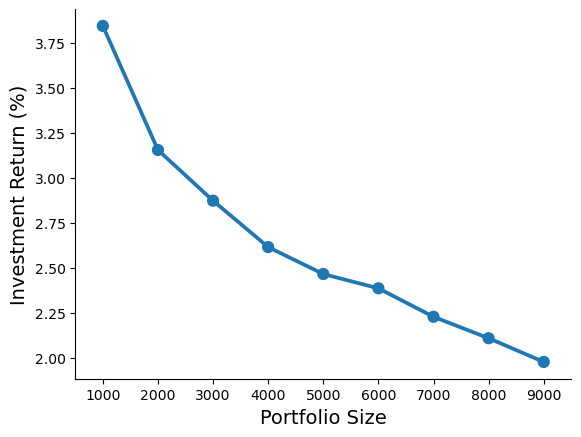

In [ ]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict=data_dict,classifier=YOURMODEL, regressor=reg_separate,
                              strategy='Default-return-based', random_state=default_seed, num_loans=num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])

result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()